In [7]:
import requests
import pandas as pd
from pytz import timezone
from scipy.optimize import curve_fit
from numpy import array, exp, inf, int64, round_
from sklearn.metrics import r2_score
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# A study on bitcoin block mining time difference

*March 2022*  
*Author: Bernardo Doré*

The good thing about working with bitcoin blockchain data is that:
- It's all on a public database
- There are multiple interfaces to it for free nowadays

We can just go out there and ask for it. https://blockchain.info has what we need.

The API will return data from all the blocks mined on the day of the timestamp. Bitcoin genesis block (height 0) was in 2009-01-03.

In [8]:
tz = timezone('UTC')
start = tz.localize(datetime(2009,1,3,12,0))
end = tz.localize(datetime(2022,2,28,23,59))

We will get block mining time data with a unix timestamp in miliseconds. We create a date range and then convert to timestamp in miliseconds:

In [9]:
date_range = pd.Series(pd.date_range(start,end,freq='D')).apply(lambda x: x.timestamp() * 1000).astype(int64)

Format the request and get the data. This can take a while.

In [ ]:
result_list = list()
for block_day in date_range:
    url = 'https://blockchain.info/blocks/{}?format=json'.format(block_day)
    r = requests.get(url)
    result = r.json()
    result_list += result
blocks_df = pd.DataFrame(result_list)

We sort by timestamp and then calculate the difference between blocks with a window of 1 row:

In [11]:
blocks_df = blocks_df.sort_values('time')
blocks_df['mining_time_diff'] = blocks_df['time'].diff(1)

Difference is in seconds so we calc the time units:

In [12]:
blocks_df['mining_time_diff_hours'] = (blocks_df['mining_time_diff'].values / 60) / 60
blocks_df['date'] = pd.to_datetime(blocks_df['time'], unit='s', utc=True)

In [13]:
blocks_df.head()

hash  height        time  \
0   000000000019d6689c085ae165831e934ff763ae46a2a6...       0  1231006505   
14  00000000839a8e6886ab5951d76f411475428afc90947e...       1  1231469665   
13  000000006a625f06636b8bb6ac7b960a8d03705d1ace08...       2  1231469744   
12  0000000082b5015589a3fdf2d4baff403e6f0be035a5d9...       3  1231470173   
11  000000004ebadb55ee9096c9a2f8880e09da59c0d68b1c...       4  1231470988   

    block_index  mining_time_diff  mining_time_diff_hours  \
0             0               NaN                     NaN   
14            1          463160.0              128.655556   
13            2              79.0                0.021944   
12            3             429.0                0.119167   
11            4             815.0                0.226389   

                        date  
0  2009-01-03 18:15:05+00:00  
14 2009-01-09 02:54:25+00:00  
13 2009-01-09 02:55:44+00:00  
12 2009-01-09 03:02:53+00:00  
11 2009-01-09 03:16:28+00:00

In [14]:
blocks_df.describe()

height          time    block_index  mining_time_diff  \
count  725212.000000  7.252120e+05  725212.000000     725211.000000   
mean   362645.508664  1.438564e+09  362645.508664        572.305162   
std    209370.848905  1.167690e+08  209370.848905        842.005417   
min         0.000000  1.231007e+09       0.000000          0.000000   
25%    181317.750000  1.337806e+09  181317.750000        165.000000   
50%    362660.500000  1.435337e+09  362660.500000        394.000000   
75%    543967.250000  1.538424e+09  543967.250000        785.000000   
max    725270.000000  1.646049e+09  725270.000000     463160.000000   

       mining_time_diff_hours  
count           725211.000000  
mean                 0.158974  
std                  0.233890  
min                  0.000000  
25%                  0.045833  
50%                  0.109444  
75%                  0.218056  
max                128.655556

We can see that the mean difference between blocks is about **572** seconds, or about **9.5** minutes.

We can also see that the max is **128** hours which is interesting. This is very far from the mean. Let's look at the outliers:

<AxesSubplot:>

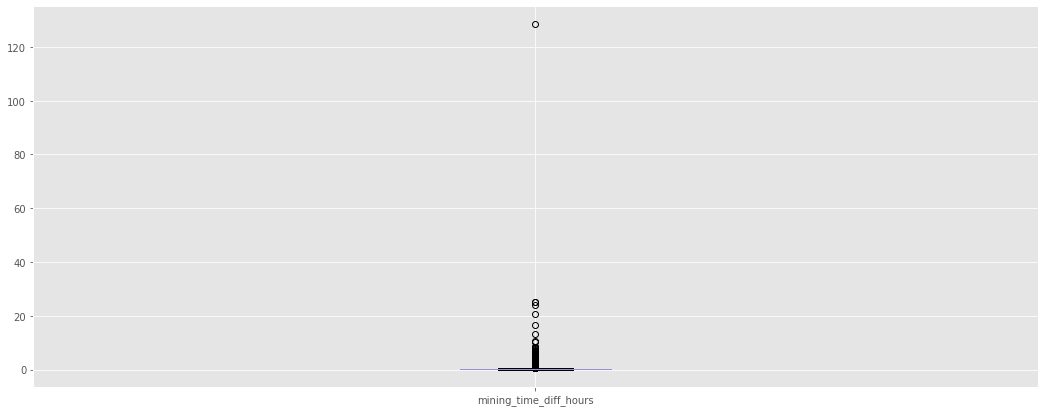

In [15]:
blocks_df.boxplot(
    'mining_time_diff_hours', figsize=(18,7)
)

We can see that there are many outliers in the data so let's check how many times it takes more than 2 hours to mine a block. We slice the dataset to keep only the blocks where the time difference is more than 2 hours:

In [16]:
overtime_blocks = blocks_df[blocks_df.mining_time_diff_hours > 2]

In [17]:
overtime_blocks.describe()

height          time    block_index  mining_time_diff  \
count     142.000000  1.420000e+02     142.000000        142.000000   
mean    29366.880282  1.253940e+09   29366.880282      19165.859155   
std     79746.399730  4.508478e+07   79746.399730      40179.255005   
min         1.000000  1.231470e+09       1.000000       7207.000000   
25%     17369.250000  1.245217e+09   17369.250000       9030.750000   
50%     20429.500000  1.249285e+09   20429.500000      11472.500000   
75%     21455.750000  1.251042e+09   21455.750000      16995.000000   
max    689301.000000  1.625144e+09  689301.000000     463160.000000   

       mining_time_diff_hours  
count              142.000000  
mean                 5.323850  
std                 11.160904  
min                  2.001944  
25%                  2.508542  
50%                  3.186806  
75%                  4.720833  
max                128.655556

We can see that it happened **142 times** in bitcoin history. When it happens, it takes on average ~ **5 hours** between blocks.

In [18]:
round_((overtime_blocks.shape[0] / blocks_df.shape[0]) * 100, 3)

0.02

It is a very infrequent event. The probability is about **0.02%**

<AxesSubplot:title={'center':'Mining time over 2 hours between blocks'}, xlabel='Date', ylabel='Difference in hours'>

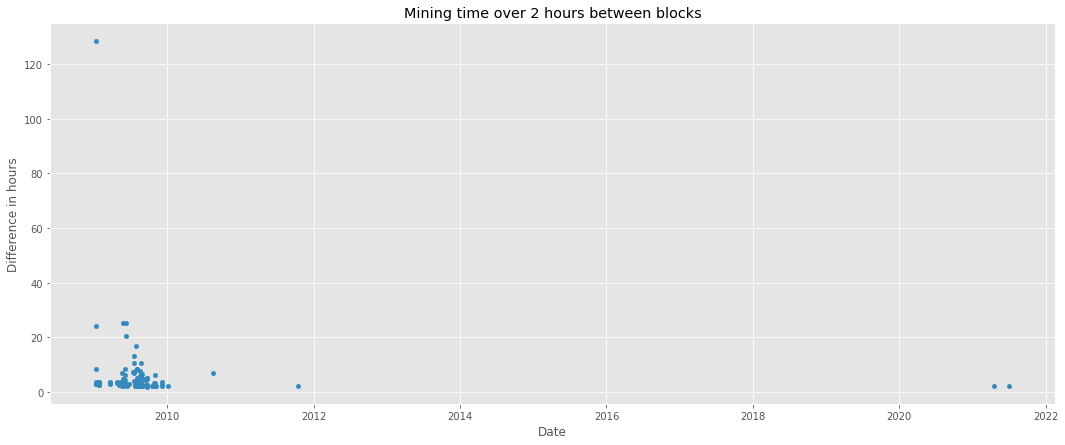

In [19]:
overtime_blocks.plot(
    'date', 
    'mining_time_diff_hours', 
    kind='scatter', 
    title='Mining time over 2 hours between blocks', 
    figsize=(18,7), 
    xlabel='Date', 
    ylabel='Difference in hours'
)

From the scatter plot we can see that the event happened quite often in bitcoin's first year 2009. It rarely happened after that.

Let's plot the histogram and take a look at the distribution of frequencies.

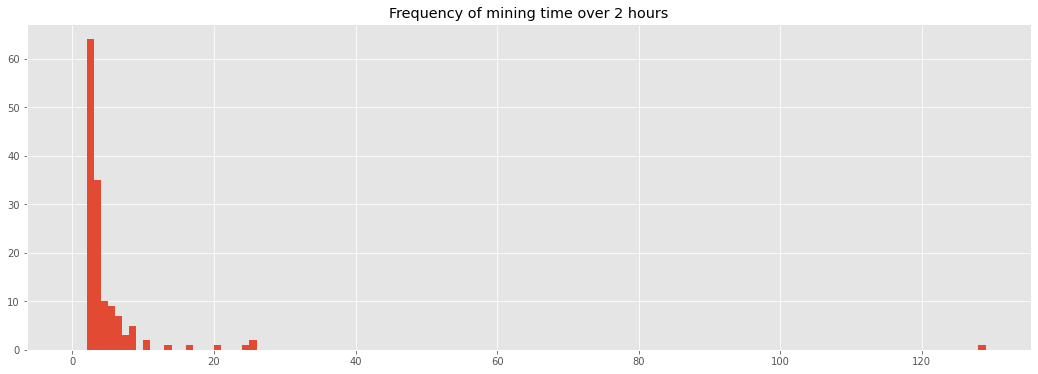

In [20]:
bins = int(round_(overtime_blocks.mining_time_diff_hours.max() + 1,0))
plt.figure(figsize=(18,6))
plt.hist(
    overtime_blocks.mining_time_diff_hours, 
    bins=range(bins)
)
plt.title('Frequency of mining time over 2 hours')
plt.show()

The data starts to resemble an exponential distribution. Let's try to fit an exponential function to the data.

First we need to produce the data for our model. We want pretty much to generate the data from the histogram.

In [21]:
model_data = pd.cut(overtime_blocks.mining_time_diff_hours, bins=range(2,bins))\
    .reset_index()\
    .groupby('mining_time_diff_hours', as_index=False)\
    .size()

In [22]:
model_data

mining_time_diff_hours  size
0                   (2, 3]    64
1                   (3, 4]    35
2                   (4, 5]    10
3                   (5, 6]     9
4                   (6, 7]     7
..                     ...   ...
122             (124, 125]     0
123             (125, 126]     0
124             (126, 127]     0
125             (127, 128]     0
126             (128, 129]     1

[127 rows x 2 columns]

There. It looks good now.

We'll define the general exponential function formula with a negative exponent:

In [23]:
def fit_exp(x, a, b):
    return a * exp(-b*x)

Separate our X and Y variables into different arrays and call curve_fit with our parameters:

In [24]:
x = model_data.index.values
y = model_data['size'].values

popt, pcov = curve_fit(fit_exp, x, y, p0=[64, 0], bounds=(0, inf))

In [25]:
popt

array([64.27662029,  0.69172843])

These are the values for parameters a and b in our exponential function. Let's do a quick inspection to see how good of a fit they are.

In [26]:
exp_model_data = fit_exp(x, *popt)

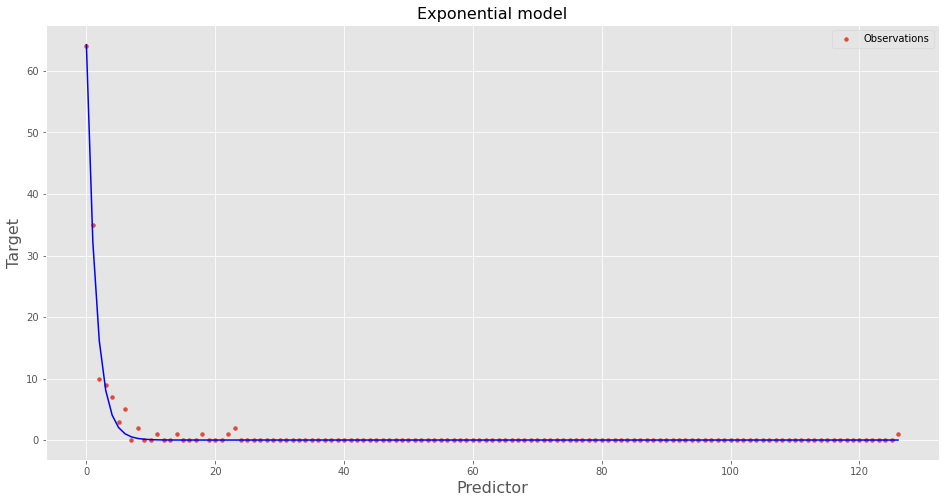

In [27]:
plt.figure(figsize=(16, 8))
plt.scatter(x, y, s=15, label='Observations')
plt.plot(x, exp_model_data, color='b')
plt.xlabel('Predictor', fontsize=16)
plt.ylabel('Target', fontsize=16)
plt.legend()
plt.title('Exponential model', fontsize=16)
plt.show()

It's taking a sharp turn maybe we can smooth that a little bit. Let's try some values for our parameter:

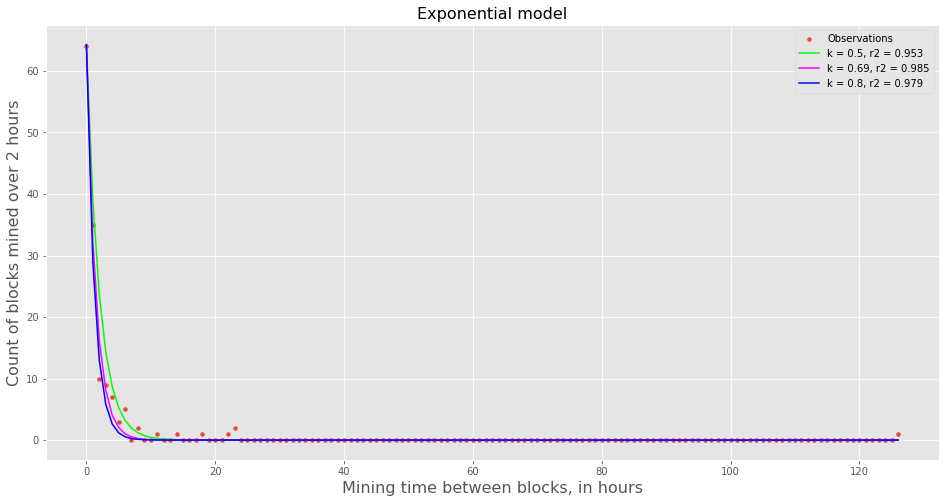

In [28]:
exp_k = [0.5, 0.69, 0.8]
colors = ['lime', 'fuchsia', 'b']
plt.figure(figsize=(16, 8))
plt.scatter(x, y, s=15, label='Observations')
for k, color in zip(exp_k, colors):
    exp_popt_test = [popt[0], k]
    exp_model_data_test = fit_exp(x, *exp_popt_test)
    r2 = round_(r2_score(y, exp_model_data_test), 3)
    plt.plot(x, exp_model_data_test, color=color, label='k = {0}, r2 = {1}'.format(k, r2))
plt.xlabel('Mining time between blocks, in hours', fontsize=16)
plt.ylabel('Count of blocks mined over 2 hours', fontsize=16)
plt.legend()
plt.title('Exponential model', fontsize=16)
plt.show()

With an $R²=0.985$ I think 0.69 is a good value if we would use to predict how many blocks would be mined when the time to mine exceeds 2 hours. 

Study by Bernardo Doré, berdore@gmail.com, 2022-03-19